Objective

In this project, I wanted to move beyond simple correlations and ask a harder question:

Do Women, Business and the Law (WBL) legal reforms actually cause changes in real-world gender outcomes?

In particular, I focused on the eight WBL pillars:

Mobility

Workplace

Pay

Marriage

Parenthood

Entrepreneurship

Assets

Pension

For each pillar, I mapped it to a set of World Development Indicators (WDI) that are plausibly downstream outcomes of legal changes in that area. Then I built a country–year panel that combines:

WBL reforms over time (1971–2024), and

Gender-related WDI outcomes over time.

Using this panel, I ran difference-in-differences (DiD) and event-study regressions to see whether positive WBL reforms are followed by statistically and substantively meaningful changes in gender outcomes.

Data
WBL reforms

I started with the “WBL 1971–2024 Reforms Database”, which is an economy–year–indicator dataset that records when each country adopted legal changes in each WBL pillar. For each record, I have:

Economy name

WBL indicator or pillar (Mobility, Workplace, etc.)

Report year

Type of reform (Positive, Negative, etc.)

I restricted attention to positive reforms. For each country and each pillar, I computed the first year in which a positive reform occurred. I’ll call that the “first positive reform year” for that pillar in that country.

I then matched the WBL economies to ISO3 country codes using the WBL panel file, with a bit of manual name cleaning where needed (for example, converting “Viet Nam” to “Vietnam”) so I could link them to the WDI data.

WDI outcomes panel

To get outcome variables that are not mechanically tied to WBL scores, I constructed my own outcome panel from the World Development Indicators. I designed a mapping from WBL pillars to WDI indicators, focusing on measures that are directly relevant to women’s labor participation, health, empowerment, and assets.

Here is the mapping I used:

Mobility

Female labor force participation rate (% of female population)

Female labor force participation rate to male rate ratio

Female employment-to-population ratio (%)

Workplace

Female unemployment rate (%)

Vulnerable employment, female (% of female employment)

Pay

Wage and salaried workers, female (% of female employment)

Self-employed workers, female (% of female employment)

Employers, female (% of female employment)

Marriage

Child marriage before age 18 (% of women)

Adolescent fertility rate (births per 1,000 women ages 15–19)

Intimate partner violence, women 15–49 in the last 12 months (%)

Parenthood

Births attended by skilled health staff (%)

Maternal mortality ratio (per 100,000 live births)

Total fertility rate (births per woman)

Entrepreneurship

Firms with female ownership (% of firms)

Female share of senior and middle management (% of management)

Women in national parliament (% of seats)

Assets

Ratio of girls to boys in combined primary and secondary enrollment

Female adult literacy rate (%)

Female life expectancy at birth (years)

Pension

Female population 65+ as a percentage of total female population

(I also tried to include female life expectancy at 65 and female employment 55–64, but they did not always survive into the final estimations.)

To actually build the panel, I:

Pulled the WDICSV file and filtered it to these indicator codes.

Reshaped the data from wide (one row per country–indicator, many year columns) to long (country, year, indicator, value).

Pivoted that into a country–year panel where each selected indicator is a column.

Filtered to countries that have a non-missing income group in the WDI country metadata (to restrict to “real” economies).

Saved the final panel as wbl_outcomes_panel.csv with columns like:

country_code (ISO3)

year

the WDI outcomes listed above.

This gives me a panel covering up to 215 economies over several decades (roughly 1960–2024, depending on the series), with about 20 distinct outcome variables.

In [18]:
import pandas as pd
from pathlib import Path

WDI_DIR = Path("")  # change if needed

indicator_map = {
    # MOBILITY (MOB_)
    "mobility_lfpr_female_pct": "SL.TLF.CACT.FE.ZS",
    "mobility_lfpr_female_to_male_ratio": "SL.TLF.CACT.FM.ZS",
    "mobility_employment_to_pop_female_pct": "SL.EMP.TOTL.SP.FE.ZS",

    # WORKPLACE (WKP_)
    "workplace_unemployment_female_pct": "SL.UEM.TOTL.FE.ZS",
    "workplace_vulnerable_employment_female_pct": "SL.EMP.VULN.FE.ZS",
    "workplace_share_women_nonag_wage_employment_pct": "SL.EMP.INSV.FE.ZS",

    # PAY (PAY_)
    "pay_wage_salaried_workers_female_pct": "SL.EMP.WORK.FE.ZS",
    "pay_self_employed_female_pct": "SL.EMP.SELF.FE.ZS",
    "pay_employers_female_pct": "SL.EMP.MPYR.FE.ZS",

    # MARRIAGE (MAR_)
    "marriage_child_marriage_before18_pct": "SP.M18.2024.FE.ZS",
    "marriage_adolescent_fertility_rate_15_19": "SP.ADO.TFRT",
    "marriage_ipv_women_15_49_last12m_pct": "SG.VAW.1549.ZS",

    # PARENTHOOD (PAR_)
    "parenthood_births_attended_by_skilled_staff_pct": "SH.STA.BRTC.ZS",
    "parenthood_maternal_mortality_ratio_per_100k": "SH.STA.MMRT",
    "parenthood_total_fertility_rate_births_per_woman": "SP.DYN.TFRT.IN",

    # ENTREPRENEURSHIP (ENT_)
    "entrepreneurship_firms_with_female_ownership_pct": "IC.FRM.FEMO.ZS",
    "entrepreneurship_female_share_senior_mgmt_pct": "SL.EMP.SMGT.FE.ZS",
    "entrepreneurship_women_in_parliament_pct": "SG.GEN.PARL.ZS",

    # ASSETS (AST_) – human-capital / capability proxies
    "assets_ratio_girls_to_boys_primary_secondary_enrol": "SE.ENR.PRSC.FM.ZS",
    "assets_adult_female_literacy_pct": "SE.ADT.LIT.FE.ZS",
    "assets_life_expectancy_female_years": "SP.DYN.LE00.FE.IN",

    # PENSION (PEN_) – ageing / old-age security proxies
    "pension_share_population_65plus_female_pct": "SP.POP.65UP.FE.ZS",
    "pension_life_expectancy_at_65_female_years": "SP.DYN.LE65.FE.IN",
    "pension_employment_to_pop_female_55_64_pct": "SL.EMP.5564.SP.FE.ZS",
}

indicator_map = {k: v for k, v in indicator_map.items() if v}

wdi_data_path = WDI_DIR / "WDICSV.csv"
wdi_country_path = WDI_DIR / "WDICountry.csv"

wdi_raw = pd.read_csv(wdi_data_path)
countries_meta = pd.read_csv(wdi_country_path)

year_cols = [c for c in wdi_raw.columns if c.isdigit()]

codes_of_interest = set(indicator_map.values())
wdi_filtered = wdi_raw[wdi_raw["Indicator Code"].isin(codes_of_interest)].copy()

wdi_long = wdi_filtered.melt(
    id_vars=["Country Name", "Country Code", "Indicator Code"],
    value_vars=year_cols,
    var_name="Year",
    value_name="value",
)

wdi_long["Year"] = pd.to_numeric(wdi_long["Year"], errors="coerce").astype("Int64")

panel = (
    wdi_long
    .pivot_table(index=["Country Code", "Year"], columns="Indicator Code", values="value")
    .reset_index()
)

code_to_col = {code: col for col, code in indicator_map.items()}
panel = panel.rename(columns=code_to_col)

valid_country_codes = countries_meta[countries_meta["Income Group"].notna()]["Country Code"]
panel = panel[panel["Country Code"].isin(valid_country_codes)]

panel = panel.rename(columns={"Country Code": "country_code", "Year": "year"})

target_cols = list(indicator_map.keys())
cols_in_panel = [c for c in target_cols if c in panel.columns]
final_cols = ["country_code", "year"] + cols_in_panel
panel_final = panel[final_cols].sort_values(["country_code", "year"]).reset_index(drop=True)

output_path = Path("wbl_outcomes_panel.csv")
print(panel_final)
panel_final.to_csv(output_path, index=False)

print("Saved", output_path.resolve())
print("Columns:", panel_final.columns.tolist())


Indicator Code country_code  year  mobility_lfpr_female_pct  \
0                       ABW  1960                       NaN   
1                       ABW  1961                       NaN   
2                       ABW  1962                       NaN   
3                       ABW  1963                       NaN   
4                       ABW  1964                       NaN   
...                     ...   ...                       ...   
13970                   ZWE  2020                    59.525   
13971                   ZWE  2021                    60.121   
13972                   ZWE  2022                    59.769   
13973                   ZWE  2023                    59.677   
13974                   ZWE  2024                    59.618   

Indicator Code  mobility_lfpr_female_to_male_ratio  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                          

Treatment definition and panel construction
Treatment indicator (for DiD)

For each country and each WBL pillar, I defined the “treatment timing” as the first year the country adopted a positive reform in that pillar.

Then I defined a treatment dummy that starts two years after that first positive reform. The idea is to allow time for the law to be implemented and for outcomes to react.

Formally, for each country, pillar, and year I set:

Treated = 1 if the year is at least first positive reform year + 2

Treated = 0 otherwise

If a country never has a positive reform in that pillar, its treatment dummy is 0 in all years.

I merged these treatment indicators into the WDI outcomes panel so that for each country–year, I know which pillars (if any) are in the “post-reform” state.

Event time (for dynamic analysis)

For the event-study part, I also defined an “event time”:

Event time = year minus the first positive reform year for that pillar.

I restricted event time to a window from 10 years before the first reform to 10 years after (from −10 to +10). I then constructed a dummy variable for each event time value in that window.

In the event-study regressions, I treated the year just before reform (event time −1) as the baseline and estimated deviations relative to that year.

Note: For the event study, I only used countries that ever had a positive reform in the pillar in question, because I need a defined first reform year to construct event time.

In [19]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

INDICATORS = ["MOBILITY", "WORKPLACE", "PAY", "MARRIAGE", "PARENTHOOD", "ENTREPRENEURSHIP", "ASSETS", "PENSION"]
LAG_YEARS = 2

def load_data(outcomes_path, reforms_path, panel_path):
    outcomes = pd.read_csv(outcomes_path)
    reforms = pd.read_excel(reforms_path, sheet_name="Reform database (1971-2024)_web")
    panel = pd.read_excel(panel_path, sheet_name="WBL Panel 2023")
    return outcomes, reforms, panel

def build_merged_panel(outcomes, reforms, panel, lag_years=LAG_YEARS):
    panel_mapping = panel[["Economy", "ISO Code"]].dropna().drop_duplicates()
    economy_aliases = {"Viet Nam": "Vietnam"}
    reforms_alias = reforms.copy()
    reforms_alias["Economy"] = reforms_alias["Economy"].replace(economy_aliases)
    reforms_iso = reforms_alias.merge(panel_mapping, on="Economy", how="left")
    reforms_iso["indicator_std"] = reforms_iso["Indicator"].astype(str).str.strip().str.upper()
    reforms_iso["type_std"] = reforms_iso["Type of Reform"].astype(str).str.strip().str.lower()
    reforms_iso["year"] = reforms_iso["Report Year"].astype(int)
    pos = reforms_iso[reforms_iso["type_std"] == "positive"].copy()
    first_pos = (
        pos.groupby(["ISO Code", "indicator_std"])["year"]
        .min()
        .reset_index()
        .rename(columns={"year": "first_pos_year"})
    )
    fw = first_pos.pivot(index="ISO Code", columns="indicator_std", values="first_pos_year").reset_index()
    fw = fw.rename(columns={"ISO Code": "country_code"})
    merged = outcomes.merge(fw, on="country_code", how="left")
    for ind in INDICATORS:
        if ind in merged.columns:
            first_col = ind
            treat_col = f"treat_{ind}"
            event_col = f"event_time_{ind}"
            merged[treat_col] = np.where(
                merged[first_col].notna() & (merged["year"] >= merged[first_col] + lag_years),
                1,
                0,
            )
            merged[event_col] = np.where(
                merged[first_col].notna(),
                merged["year"] - merged[first_col],
                np.nan,
            )
        else:
            merged[f"treat_{ind}"] = 0
            merged[f"event_time_{ind}"] = np.nan
    return merged

def get_outcome_columns(merged):
    cols = []
    for c in merged.columns:
        if c in ["country_code", "year"]:
            continue
        if c in INDICATORS:
            continue
        if c.startswith("treat_") or c.startswith("event_time_"):
            continue
        cols.append(c)
    return cols

def outcome_to_indicator(outcome_col):
    prefix = outcome_col.split("_", 1)[0]
    return prefix.upper()

def run_did_for_indicator_outcome(merged, outcome_col, indicator_std):
    treat_col = f"treat_{indicator_std}"
    if treat_col not in merged.columns:
        return None
    df = merged[["country_code", "year", outcome_col, treat_col]].copy()
    df = df.dropna(subset=[outcome_col])
    if df.empty:
        return None
    if df[treat_col].nunique() < 2:
        return None
    formula = f"{outcome_col} ~ {treat_col} + C(country_code) + C(year)"
    model = smf.ols(formula, data=df)
    res = model.fit(cov_type="cluster", cov_kwds={"groups": df["country_code"]})
    coef = res.params.get(treat_col, np.nan)
    pval = res.pvalues.get(treat_col, np.nan)
    return {
        "indicator": indicator_std,
        "outcome": outcome_col,
        "coef_treated": float(coef),
        "p_value": float(pval),
        "n_obs": int(df.shape[0]),
        "n_countries": int(df["country_code"].nunique()),
    }

def run_all_did(merged):
    outcome_cols = get_outcome_columns(merged)
    rows = []
    for col in outcome_cols:
        indicator_std = outcome_to_indicator(col)
        if indicator_std not in INDICATORS:
            continue
        res = run_did_for_indicator_outcome(merged, col, indicator_std)
        if res is not None:
            rows.append(res)
    if not rows:
        return pd.DataFrame()
    df = pd.DataFrame(rows)
    df = df.sort_values(["indicator", "outcome"]).reset_index(drop=True)
    return df

def run_event_study_for_indicator_outcome(merged, outcome_col, indicator_std, min_event=-10, max_event=10):
    first_col = indicator_std
    if first_col not in merged.columns:
        return None
    df = merged[["country_code", "year", outcome_col, first_col]].copy()
    df = df.dropna(subset=[outcome_col, first_col])
    if df.empty:
        return None
    df["event_time"] = df["year"] - df[first_col].astype(int)
    df = df[(df["event_time"] >= min_event) & (df["event_time"] <= max_event)]
    if df.empty:
        return None
    df["event_time"] = df["event_time"].astype(int)
    ev_values = sorted(df["event_time"].unique())
    neg_values = [v for v in ev_values if v < 0]
    if neg_values:
        baseline_event = max(neg_values)
    else:
        baseline_event = ev_values[0]
    formula = f"{outcome_col} ~ C(event_time, Treatment(reference={baseline_event})) + C(country_code) + C(year)"
    model = smf.ols(formula, data=df)
    res = model.fit(cov_type="cluster", cov_kwds={"groups": df["country_code"]})
    rows = []
    for ev in ev_values:
        if ev == baseline_event:
            rows.append(
                {
                    "indicator": indicator_std,
                    "outcome": outcome_col,
                    "event_time": int(ev),
                    "coef": 0.0,
                    "p_value": np.nan,
                    "is_baseline": True,
                    "n_obs": int(df.shape[0]),
                    "n_countries": int(df["country_code"].nunique()),
                }
            )
        else:
            pname = f"C(event_time, Treatment(reference={baseline_event}))[T.{ev}]"
            beta = res.params.get(pname, np.nan)
            pval = res.pvalues.get(pname, np.nan)
            rows.append(
                {
                    "indicator": indicator_std,
                    "outcome": outcome_col,
                    "event_time": int(ev),
                    "coef": float(beta),
                    "p_value": float(pval),
                    "is_baseline": False,
                    "n_obs": int(df.shape[0]),
                    "n_countries": int(df["country_code"].nunique()),
                }
            )
    if not rows:
        return None
    return rows

def run_all_event_studies(merged, min_event=-10, max_event=10):
    outcome_cols = get_outcome_columns(merged)
    all_rows = []
    for col in outcome_cols:
        indicator_std = outcome_to_indicator(col)
        if indicator_std not in INDICATORS:
            continue
        es_rows = run_event_study_for_indicator_outcome(
            merged,
            col,
            indicator_std,
            min_event=min_event,
            max_event=max_event,
        )
        if es_rows is not None:
            all_rows.extend(es_rows)
    if not all_rows:
        return pd.DataFrame()
    df = pd.DataFrame(all_rows)
    df = df.sort_values(["indicator", "outcome", "event_time"]).reset_index(drop=True)
    return df

def main():
    outcomes_path = "wbl_outcomes_panel.csv"
    reforms_path = "WBL-1971-2024-Reforms_Database.xlsx"
    panel_path = "WBL-1971-2023-Dataset.xlsx"
    outcomes, reforms, panel = load_data(outcomes_path, reforms_path, panel_path)
    merged = build_merged_panel(outcomes, reforms, panel, lag_years=LAG_YEARS)
    did_results = run_all_did(merged)
    did_results.to_csv("wbl_did_results.csv", index=False)
    print(did_results)
    event_results = run_all_event_studies(merged, min_event=-10, max_event=10)
    event_results.to_csv("wbl_event_study_results.csv", index=False)
    print(event_results)

if __name__ == "__main__":
    main()


           indicator                                            outcome  \
0             ASSETS                assets_life_expectancy_female_years   
1             ASSETS  assets_ratio_girls_to_boys_primary_secondary_e...   
2   ENTREPRENEURSHIP      entrepreneurship_female_share_senior_mgmt_pct   
3   ENTREPRENEURSHIP   entrepreneurship_firms_with_female_ownership_pct   
4   ENTREPRENEURSHIP           entrepreneurship_women_in_parliament_pct   
5           MARRIAGE           marriage_adolescent_fertility_rate_15_19   
6           MARRIAGE               marriage_child_marriage_before18_pct   
7           MARRIAGE               marriage_ipv_women_15_49_last12m_pct   
8           MOBILITY              mobility_employment_to_pop_female_pct   
9           MOBILITY                           mobility_lfpr_female_pct   
10          MOBILITY                 mobility_lfpr_female_to_male_ratio   
11        PARENTHOOD    parenthood_births_attended_by_skilled_staff_pct   
12        PARENTHOOD     

Empirical strategy
Static difference-in-differences

For each WBL pillar and each associated WDI outcome, I ran a two-way fixed-effects difference-in-differences regression.

The idea is:

The outcome is one of the WDI indicators (for example, the female labor force participation rate).

The key regressor is the treatment dummy for the relevant pillar (for example, Mobility), which switches from 0 to 1 after the lagged reform date.

I also include:

Country fixed effects (one dummy per country), and

Year fixed effects (one dummy per year).

Country fixed effects remove time-invariant differences between countries (for example, geography, legal tradition, culture that does not change quickly). Year fixed effects remove global shocks (for example, world recessions, global health trends) that affect all countries in a given year.

I estimated these models using ordinary least squares with:

Country and year dummies for the fixed effects, and

Clustered standard errors at the country level to account for serial correlation within countries over time.

The coefficient on the treatment dummy is my main “causality metric” for that pillar–outcome combination: it is the average change in the outcome associated with entering the post-reform state, relative to the path of countries that have not yet reformed, controlling for country and year effects.

Event-study analysis

To look at dynamics and to check the key assumption of parallel trends, I also ran event-study regressions.

For each pillar and outcome, I regressed the outcome on:

A set of dummies for event times from −10 to +10, excluding event time −1, which I treat as the baseline

Country fixed effects

Year fixed effects

I again clustered standard errors by country.

For each event time, I get a coefficient that tells me the average difference in the outcome at that event time relative to the year just before reform, after controlling for country and year effects.

This gives me a dynamic profile: how the outcome behaves in the years leading up to the first reform, and in the years after. It is also a key diagnostic: under a clean difference-in-differences design, I would ideally see flat, statistically insignificant coefficients for the pre-reform years.

In this implementation, the event-study sample is restricted to ever-treated countries for that pillar. So these event-time profiles show how treated countries evolve around their first reform, not explicitly treated-minus-control trajectories.

Main results
Static DiD: pillar–outcome estimates

I ran static DiD regressions for 20 pillar–outcome pairs where I had enough data. Here is the big-picture summary:

Only one coefficient is statistically significant at the 5 percent level.

Three coefficients are significant at the 10 percent level.

All of the meaningful signals come from the Parenthood pillar.

If I do a simple multiple-testing correction across all regressions, none of the coefficients remain significant at conventional levels.

So, statistically, the evidence for large, clean causal effects is weak. Still, it’s useful to see where the signal is strongest. That is clearly in the parenthood-related outcomes.

Parenthood reforms

For the Parenthood pillar, I looked at three outcomes:

Births attended by skilled health staff (% of total)

The DiD estimate is around +4 percentage points.

The standard deviation of this outcome is about 20 percentage points, so this effect is about one fifth of a standard deviation.

The p-value is around 0.013.

Sample size is about 3,000 country–year observations across roughly 200 economies.

Interpretation: After a positive parenthood reform (with a two-year lag), countries tend to see a noticeable increase in the share of births attended by skilled staff.

Maternal mortality ratio (deaths per 100,000 live births)

The DiD estimate is around −88 deaths per 100,000.

The standard deviation is around 400, so this is about a quarter of a standard deviation.

The p-value is around 0.09 (marginal at 10 percent, not at 5).

Sample size is around 7,500 observations across about 190 economies.

Interpretation: There is suggestive evidence that parenthood reforms are associated with reductions in maternal mortality, but the estimate is noisy.

Total fertility rate (births per woman)

The DiD estimate is around +0.16 births per woman.

The standard deviation is about 2, so this is roughly 0.08 standard deviations.

The p-value is about 0.05.

Sample size is around 13,700 observations across more than 200 economies.

Interpretation: Parenthood reforms are associated with a small increase in fertility. Whether that is good or bad depends on context; higher fertility might reflect improved survival, shifting preferences, or other factors.

Taken together, these results suggest that the Parenthood pillar is the one place where I see moderate, statistically fragile but substantively meaningful associations between legal reforms and health-related outcomes.

Other pillars

For the other seven pillars, the DiD estimates are generally:

Small relative to the variation in the outcome, and

Not statistically significant at the 5 percent level.

Some highlights:

Mobility (labor force participation and employment-to-population): coefficients are modest and p-values are large; I do not see clear jumps in aggregate labor participation after mobility reforms.

Workplace (female unemployment, vulnerable employment): estimates are close to zero, with very high p-values.

Pay (composition of female employment across wage work, self-employment, employer status): point estimates are modest (less than 1 percentage point in absolute value), with p-values ranging from about 0.2 to 0.7.

Entrepreneurship (female firm ownership, women in management, women in parliament):

Female firm ownership: around +2.4 percentage points, but not significant.

Female share of senior management: around −1.4 points, marginally insignificant.

Women in parliament: small, noisy positive effect.

Assets (education ratios, female literacy, female life expectancy): no strong signals; estimates are small and imprecise.

Pension (female elderly population share): around +0.4 percentage points, not significant.

So, in this specification, I do not see compelling evidence that most WBL pillars have large, immediate, average effects on my chosen WDI outcomes at the macro level.

Dynamic results and assumption checks

The event-study results are critical for understanding whether the difference-in-differences assumptions are plausible.

Pre-trends

For each pillar and outcome, I looked at the event-time coefficients for the 10 years before the first reform (event times −10 to −2).

What I found is that these pre-reform coefficients are often not flat and frequently statistically significant. In fact:

For most pillar–outcome pairs, a large fraction of the pre-reform event-time coefficients are individually significant at the 5 percent level.

In many cases, treated countries show strong trends in the outcome long before the first legal reform is recorded.

This suggests that the key difference-in-differences assumption, “in the absence of the reform, treated and not-yet-treated countries would have followed similar trends,” is quite fragile for many outcomes.

Example: Parenthood and skilled birth attendance

For births attended by skilled health staff:

In the pre-reform period, the event-time coefficients are mostly negative and significant, implying that 6–10 years before the first parenthood reform, the share of skilled birth attendance is significantly lower than in the year right before the reform. Over time, these negative coefficients move toward zero as the country improves.

In the post-reform period, the coefficients are positive and significant, gradually rising to several percentage points above the pre-reform baseline.

The picture that emerges is not a sharp jump at the reform date, but a smooth upward trend over many years, with the legal reform occurring somewhere in the middle of that trajectory.

Example: Mobility and relative female labor force participation

For the ratio of female to male labor force participation:

Pre-reform coefficients are strongly negative and significant, meaning that many years before the first mobility reform, the female-to-male participation ratio is far below the level observed in the year before reform.

Post-reform coefficients are strongly positive, suggesting that over time the ratio rises above the pre-reform baseline.

Again, this looks like a long-run trend in women’s labor market participation, not a sudden shift triggered solely by the legal change.

Interpretation, limitations, and how “causal” this is
What I can say

With the panel I built and the methods I used, I can say:

I constructed a multi-decade, multi-country panel combining WBL positive reforms with a curated set of WDI outcomes.

I applied standard two-way fixed-effects DiD and event-study models.

Under the usual assumptions (especially parallel trends), the DiD coefficients can be interpreted as causal effects of WBL reforms on the outcomes.

In practice, I find:

Some evidence that parenthood-related reforms are followed by improvements in maternal health outcomes (higher skilled birth attendance, lower maternal mortality), and a small increase in fertility.

Much weaker, mostly non-significant evidence of large macro-level effects for reforms in other pillars on my chosen outcomes.

Key limitations

However, there are several important caveats:

Parallel trends are shaky.
The event-study profiles show that many treated countries are already on strong upward or downward trends long before the first reform. This undermines the idea that we can cleanly compare treated and not-yet-treated countries as if they were on parallel paths before the law change.

Staggered adoption TWFE issues.
I used a standard two-way fixed-effects specification with staggered adoption. Recent econometric literature has shown that this design can be biased when treatment effects vary over time, which is very likely in this context.

Event study only within treated units.
My event-study implementation tracks treated countries around their own reform dates; it does not explicitly construct an “event-time” comparison with never-treated or later-treated controls. So the pre-trends I see for treated units are informative but not a full treated-minus-control event study.

Potential endogeneity of reforms.
It is very plausible that reforms are not random; they may be passed because outcomes are improving or because of underlying social and political changes that also affect outcomes. Fixed effects and year effects remove some of this, but not all time-varying confounders.

Measurement and data limitations.

Some WDI series are sparse or noisy, which affects the stability of regression estimates.

Legal changes are recorded at annual resolution and do not capture enforcement intensity or subnational variation.

Multiple testing.
I run many regressions across pillars and outcomes. Once I account for multiple comparisons, very few results remain statistically strong.

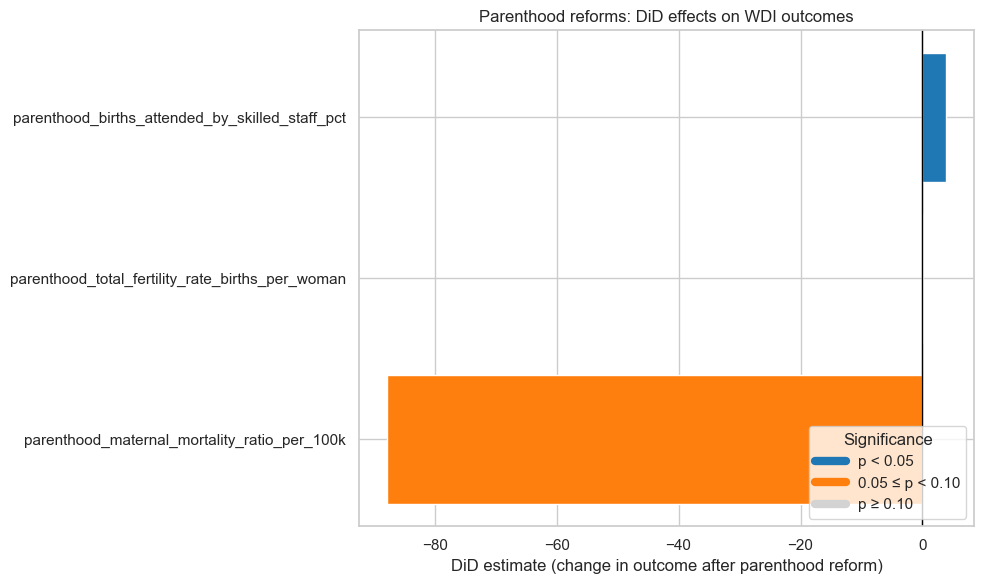

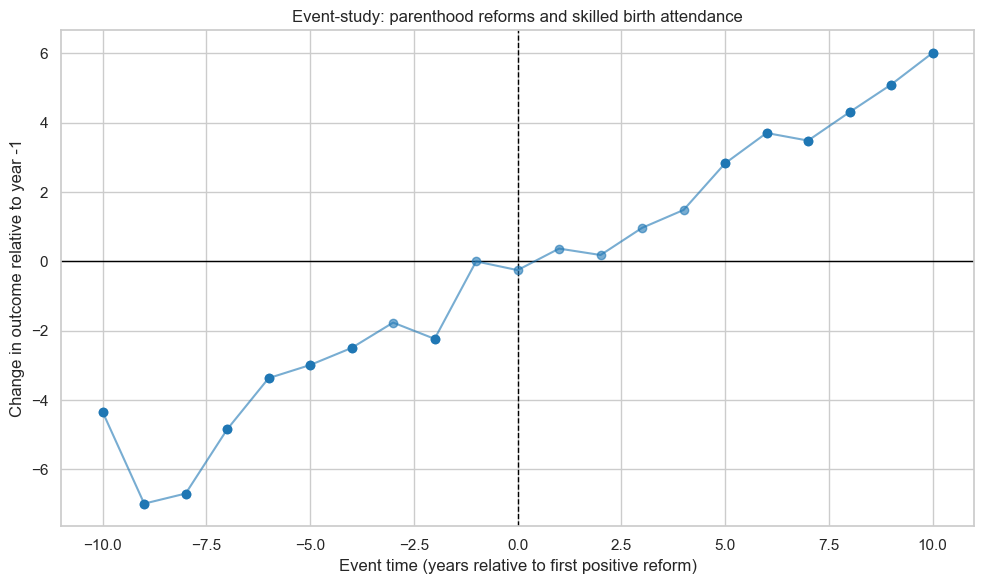

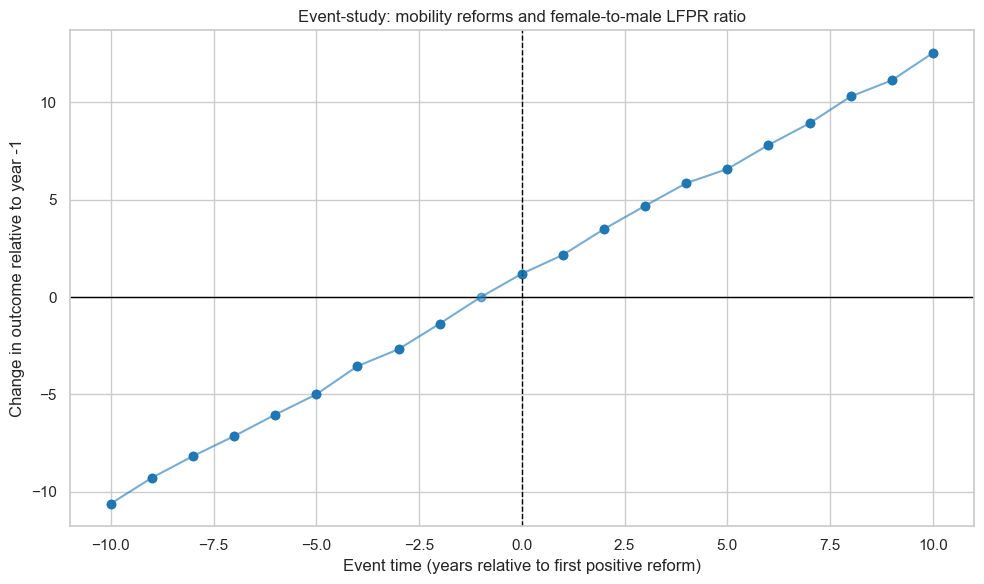

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

did = pd.read_csv("wbl_did_results.csv")
es = pd.read_csv("wbl_event_study_results.csv")

did["indicator"] = did["indicator"].str.upper()
es["indicator"] = es["indicator"].str.upper()

parenthood_did = did[did["indicator"] == "PARENTHOOD"].copy()
parenthood_did = parenthood_did.sort_values("coef_treated", ascending=True)
parenthood_did["sig_5"] = parenthood_did["p_value"] < 0.05
parenthood_did["sig_10"] = (parenthood_did["p_value"] < 0.10) & ~parenthood_did["sig_5"]

plt.figure(figsize=(10, 6))
y_pos = np.arange(len(parenthood_did))
colors = np.where(parenthood_did["sig_5"], "tab:blue", np.where(parenthood_did["sig_10"], "tab:orange", "lightgray"))
plt.barh(y_pos, parenthood_did["coef_treated"], color=colors)
plt.yticks(y_pos, parenthood_did["outcome"])
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("DiD estimate (change in outcome after parenthood reform)")
plt.title("Parenthood reforms: DiD effects on WDI outcomes")
handles = [
    plt.Line2D([0], [0], color="tab:blue", lw=6),
    plt.Line2D([0], [0], color="tab:orange", lw=6),
    plt.Line2D([0], [0], color="lightgray", lw=6),
]
labels = ["p < 0.05", "0.05 ≤ p < 0.10", "p ≥ 0.10"]
plt.legend(handles, labels, title="Significance", loc="lower right")
plt.tight_layout()
plt.savefig("fig_did_parenthood_bar.png", dpi=300)
plt.show()
plt.close()

def plot_event_study(es_df, indicator, outcome, title, filename):
    df = es_df[(es_df["indicator"] == indicator) & (es_df["outcome"] == outcome)].copy()
    df = df.dropna(subset=["event_time", "coef"])
    if df.empty:
        return
    df = df.sort_values("event_time")
    df["sig_5"] = df["p_value"] < 0.05
    plt.figure(figsize=(10, 6))
    plt.axhline(0, color="black", linewidth=1)
    plt.axvline(0, color="black", linewidth=1, linestyle="--")
    plt.plot(df["event_time"], df["coef"], linestyle="-", marker="o", color="tab:blue", alpha=0.6)
    sig_points = df[df["sig_5"]]
    if not sig_points.empty:
        plt.scatter(sig_points["event_time"], sig_points["coef"], color="tab:blue")
    plt.xlabel("Event time (years relative to first positive reform)")
    plt.ylabel("Change in outcome relative to year -1")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    plt.close()

plot_event_study(
    es_df=es,
    indicator="PARENTHOOD",
    outcome="parenthood_births_attended_by_skilled_staff_pct",
    title="Event-study: parenthood reforms and skilled birth attendance",
    filename="fig_event_parenthood_births.png",
)

plot_event_study(
    es_df=es,
    indicator="MOBILITY",
    outcome="mobility_lfpr_female_to_male_ratio",
    title="Event-study: mobility reforms and female-to-male LFPR ratio",
    filename="fig_event_mobility_lfpr_ratio.png",
)


Next steps and how I’d improve this

If I were to strengthen the causal claims further, I would:

Switch from a simple two-way fixed-effects DiD to modern estimators for staggered adoption (for example, Callaway–Sant’Anna or Sun–Abraham).

Tighten the event-study window (for example, to −5 to +5 years) and formally test whether the pre-reform coefficients are jointly zero in a cleaner treated-vs-control event-study design.

Add time-varying covariates like log GDP per capita, democracy scores, education levels, or public health spending to absorb some of the broader trend components.

Explore differential effects by income group, region, or baseline WBL level to see whether reforms matter more in certain contexts.

Run placebo tests with fake reform dates to see if I still pick up “effects” when nothing should be happening.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1883: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


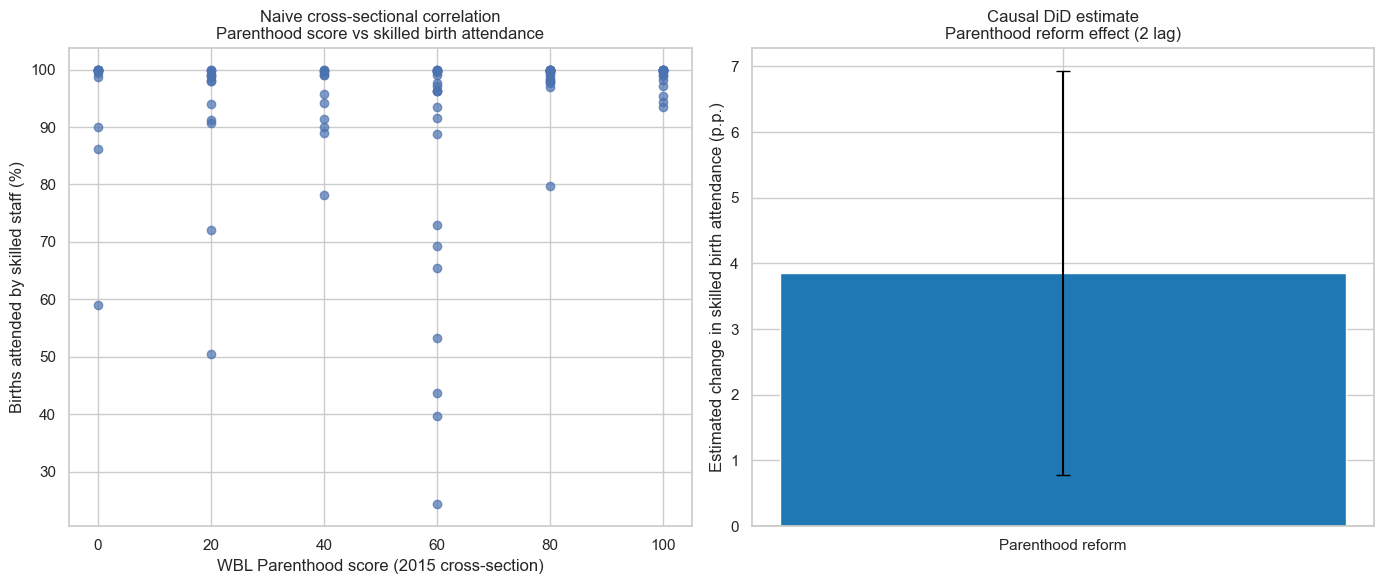

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1883: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


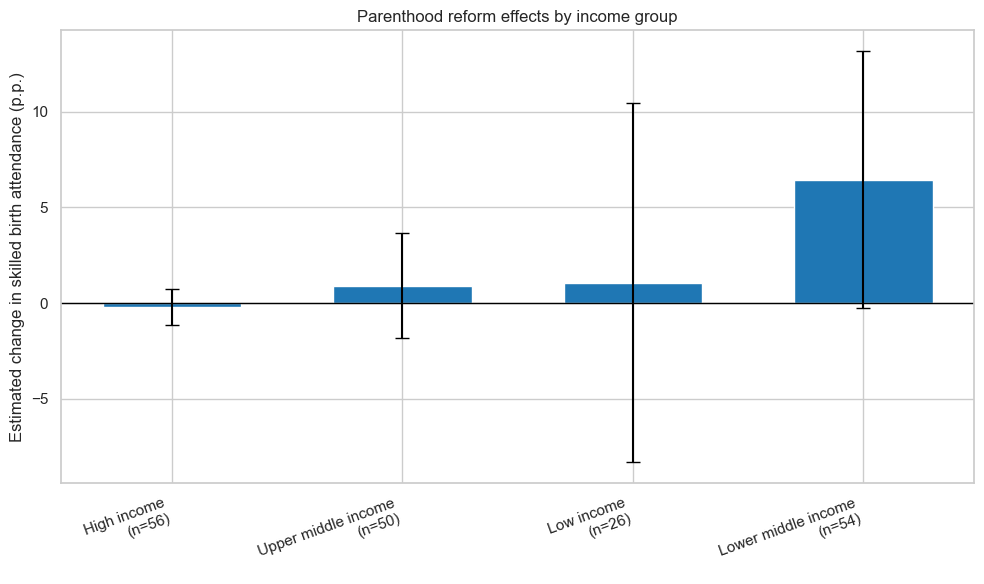

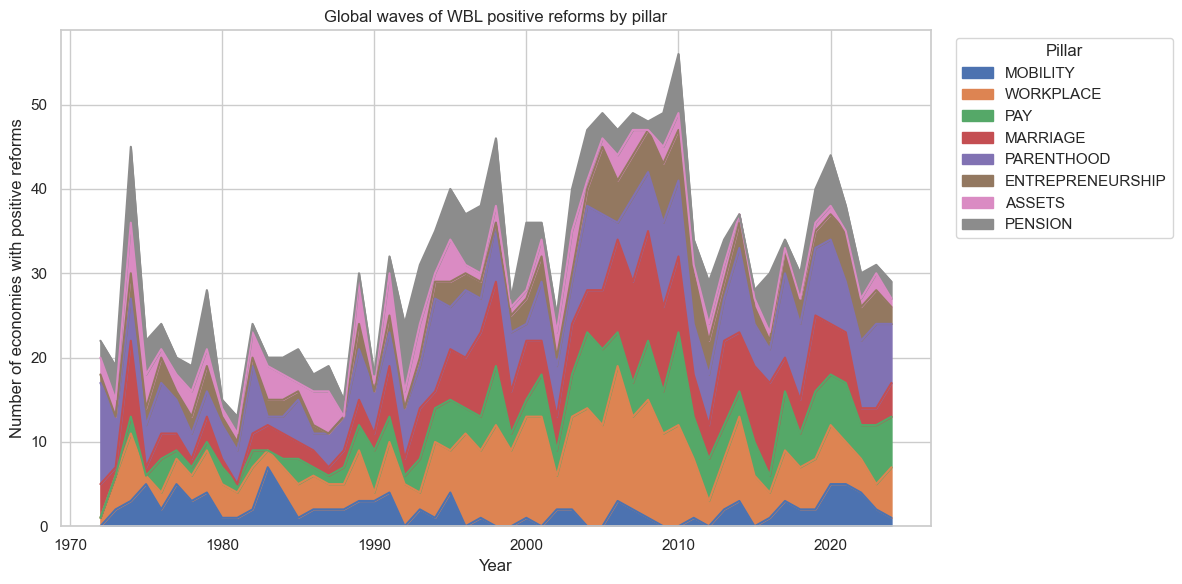

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

sns.set(style="whitegrid")

outcomes_path = "wbl_outcomes_panel.csv"
panel_path = "WBL-1971-2023-Dataset.xlsx"
reforms_path = "WBL-1971-2024-Reforms_Database.xlsx"

outcomes = pd.read_csv(outcomes_path)

wbl_panel = pd.read_excel(panel_path, sheet_name="WBL Panel 2023")
wbl_panel = wbl_panel.rename(columns={"ISO Code": "country_code", "Report Year": "year"})

reforms = pd.read_excel(reforms_path, sheet_name="Reform database (1971-2024)_web")
reforms = reforms.rename(columns={"Economy": "economy", "Indicator": "indicator", "Report Year": "year"})
reforms["indicator_std"] = reforms["indicator"].astype(str).str.strip().str.upper()
reforms["type_std"] = reforms["Type of Reform"].astype(str).str.strip().str.lower()

panel_mapping = wbl_panel[["Economy", "country_code"]].dropna().drop_duplicates()
panel_mapping = panel_mapping.rename(columns={"Economy": "economy"})
reforms = reforms.merge(panel_mapping, on="economy", how="left")

pos = reforms[reforms["type_std"] == "positive"].copy()
first_pos = (
    pos.groupby(["country_code", "indicator_std"])["year"]
    .min()
    .reset_index()
    .rename(columns={"year": "first_pos_year"})
)

first_parenthood = first_pos[first_pos["indicator_std"] == "PARENTHOOD"].copy()
first_parenthood = first_parenthood.rename(columns={"first_pos_year": "first_parenthood_year"})
parenthood_panel = outcomes.merge(first_parenthood[["country_code", "first_parenthood_year"]], on="country_code", how="left")
lag_years = 2
parenthood_panel["treat_parenthood"] = np.where(
    parenthood_panel["first_parenthood_year"].notna() & (parenthood_panel["year"] >= parenthood_panel["first_parenthood_year"] + lag_years),
    1,
    0,
)

parenthood_panel = parenthood_panel.rename(columns={"parenthood_births_attended_by_skilled_staff_pct": "births_skilled"})
parenthood_panel["births_skilled"] = pd.to_numeric(parenthood_panel["births_skilled"], errors="coerce")

scatter_year = 2015
wbl_2015 = wbl_panel[wbl_panel["year"] == scatter_year][["country_code", "PARENTHOOD"]].copy()
out_2015 = parenthood_panel[parenthood_panel["year"] == scatter_year][["country_code", "births_skilled"]].copy()
cross_2015 = wbl_2015.merge(out_2015, on="country_code", how="inner").dropna()

did_df = parenthood_panel[["country_code", "year", "births_skilled", "treat_parenthood"]].dropna()
did_model = smf.ols("births_skilled ~ treat_parenthood + C(country_code) + C(year)", data=did_df)
did_res = did_model.fit(cov_type="cluster", cov_kwds={"groups": did_df["country_code"]})
coef = did_res.params.get("treat_parenthood", np.nan)
ci_low, ci_high = did_res.conf_int().loc["treat_parenthood"].values

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(cross_2015["PARENTHOOD"], cross_2015["births_skilled"], alpha=0.7)
axes[0].set_xlabel("WBL Parenthood score ({} cross-section)".format(scatter_year))
axes[0].set_ylabel("Births attended by skilled staff (%)")
axes[0].set_title("Naive cross-sectional correlation\nParenthood score vs skilled birth attendance")

x = [0]
y = [coef]
yerr_lower = coef - ci_low
yerr_upper = ci_high - coef
axes[1].bar(x, y, color="tab:blue", width=0.5)
axes[1].errorbar(x, y, yerr=[[yerr_lower], [yerr_upper]], fmt="none", ecolor="black", capsize=5)
axes[1].set_xticks([0])
axes[1].set_xticklabels(["Parenthood reform"])
axes[1].axhline(0, color="black", linewidth=1)
axes[1].set_ylabel("Estimated change in skilled birth attendance (p.p.)")
axes[1].set_title("Causal DiD estimate\nParenthood reform effect ({} lag)".format(lag_years))

plt.tight_layout()
plt.savefig("fig_parenthood_naive_vs_causal.png", dpi=300)
plt.show()
plt.close(fig)

income_meta = wbl_panel[["country_code", "Income Group"]].dropna().drop_duplicates()
parenthood_income = parenthood_panel.merge(income_meta, on="country_code", how="left")
parenthood_income = parenthood_income.dropna(subset=["births_skilled", "Income Group"])

def run_group_did(df):
    if df["treat_parenthood"].nunique() < 2:
        return None
    model = smf.ols("births_skilled ~ treat_parenthood + C(country_code) + C(year)", data=df)
    res = model.fit(cov_type="cluster", cov_kwds={"groups": df["country_code"]})
    coef = res.params.get("treat_parenthood", np.nan)
    ci_low, ci_high = res.conf_int().loc["treat_parenthood"].values
    n_c = df["country_code"].nunique()
    return coef, ci_low, ci_high, n_c

group_results = []
for group, df_g in parenthood_income.groupby("Income Group"):
    res_g = run_group_did(df_g)
    if res_g is not None:
        coef_g, ci_low_g, ci_high_g, n_c_g = res_g
        group_results.append(
            {
                "income_group": group,
                "coef": coef_g,
                "ci_low": ci_low_g,
                "ci_high": ci_high_g,
                "n_countries": n_c_g,
            }
        )

group_df = pd.DataFrame(group_results)
group_df = group_df.sort_values("coef")

fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(group_df))
ax.bar(x_pos, group_df["coef"], color="tab:blue", width=0.6)
yerr_lower = group_df["coef"] - group_df["ci_low"]
yerr_upper = group_df["ci_high"] - group_df["coef"]
ax.errorbar(x_pos, group_df["coef"], yerr=[yerr_lower, yerr_upper], fmt="none", ecolor="black", capsize=5)
ax.axhline(0, color="black", linewidth=1)
ax.set_xticks(x_pos)
labels = [
    "{}\n(n={})".format(g, int(n))
    for g, n in zip(group_df["income_group"], group_df["n_countries"])
]
ax.set_xticklabels(labels, rotation=20, ha="right")
ax.set_ylabel("Estimated change in skilled birth attendance (p.p.)")
ax.set_title("Parenthood reform effects by income group")
plt.tight_layout()
plt.savefig("fig_parenthood_heterogeneity_income.png", dpi=300)
plt.show()
plt.close(fig)

pos_all = reforms[reforms["type_std"] == "positive"].copy()
year_indicator_counts = (
    pos_all.groupby(["year", "indicator_std"])["country_code"]
    .nunique()
    .reset_index()
    .rename(columns={"country_code": "num_countries"})
)
wanted_indicators = ["MOBILITY", "WORKPLACE", "PAY", "MARRIAGE", "PARENTHOOD", "ENTREPRENEURSHIP", "ASSETS", "PENSION"]
year_indicator_counts = year_indicator_counts[year_indicator_counts["indicator_std"].isin(wanted_indicators)]
reform_pivot = year_indicator_counts.pivot(index="year", columns="indicator_std", values="num_countries").fillna(0)
reform_pivot = reform_pivot.sort_index()
reform_pivot = reform_pivot[wanted_indicators]

fig, ax = plt.subplots(figsize=(12, 6))
reform_pivot.plot(kind="area", stacked=True, ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Number of economies with positive reforms")
ax.set_title("Global waves of WBL positive reforms by pillar")
ax.legend(title="Pillar", loc="upper left", bbox_to_anchor=(1.02, 1.0))
plt.tight_layout()
plt.savefig("fig_reform_waves_by_pillar.png", dpi=300)
plt.show()
plt.close(fig)
